# GDP-08 한영 번역기 만들기 


* GDL-07에서 다뤘던 이론 내용을 토대로 Seq2seq를 이용해 한영 번역기를 만들어봅니다.
* 코드는 GDP-08 에서 제공한 코드를 사용합니다. 멋진 번역기, 함 만들어 봅시다! 

In [1]:
# 구글 드라이브 마운트 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


\\

----

# 루브릭 평가 기준 


| 평가문항 | 상세기준 |
| --- | --- |
| 1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다. | 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다. |
| 2. Attentional Seq2seq 모델이 정상적으로 구동된다. | seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다. |
| 3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. | 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다. |

\\

----

# 1. 데이터 및 라이브러리 불러오기 


* 프로젝트 진행에 필요한 데이터셋을 다운받고, 라이브러리를 import 합니다.
* 라이브러리 버전 확인도 해 보죠! 
* 이번 시간에는 한국어 데이터를 다루기 때문에, 한글 폰트 설치는 필수입니다. 

## &nbsp;&nbsp; 1-1 라이브러리 불러오기 


* 실습에 필요한 라이브러리를 불러옵니다.
* 한국어 폰트도 설치 해 줍니다.

In [2]:
import pandas as pd
import numpy as np
import os, re, random, io 
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

In [3]:
# 폰트 설치!
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/content/drive/MyDrive/AIFFEL/font/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [4]:
# 폰트 설치 - 폰트 깨졌을 때! 
# 폰트 설치 후, 런타임 재시작 해야 안깨짐 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


## &nbsp;&nbsp; 1-2 데이터 불러오기


* 이번시간에 사용할 데이터셋은 [korean-english-news-v1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1) 입니다. 
* 데이터셋을 다운받고, 프로젝트에 활용할 수 있게 gz 압축을 해재 합니다. 

In [5]:
# 데이터셋이 있는 디렉토리로 이동합니다. 
os.chdir('/content/drive/MyDrive/AIFFEL/mkdir/s2s_translation')

In [6]:
# 데이터 압축 풀기  - train 
# !tar -xzvf korean-english-park.train.tar.gz

In [7]:
# 데이터 압축 풀기 - test 
# !tar -xzvf korean-english-park.test.tar.gz

In [8]:
# 폴더 내 파일 확인 
! ls

korean-english-park.test.en	 korean-english-park.train.en
korean-english-park.test.ko	 korean-english-park.train.ko
korean-english-park.test.tar.gz  korean-english-park.train.tar.gz


In [9]:
# train 데이터 할당 
path_ko_train = 'korean-english-park.train.ko'
path_en_train = 'korean-english-park.train.en'

In [10]:
# 불러오기 
with open(path_ko_train, "r") as f:
    ko_train = f.read().splitlines()

print("Data Size:", len(ko_train))

print("Example:")
for sen in ko_train[20:45]: print(">>", sen)

Data Size: 94123
Example:
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> 말레이시아의 수도 쿠알라 룸푸르에서 열리는 이틀간의 회담에서는 1970년대와 80년대에 있었던 일본 민간인들의 납치에 대한 보다 충분한 설명을 요청하는 것 뿐만아니라 북한의 (핵)폭탄 제조 노력에 대한 일본의 우려가 주로 논의될 것으로 예상되고 있다.
>> 100여명의 사망자가 예상되는 베트남 빌딩 화재
>> 상점, 디스코텍, 그리고 여러 외국 회사들이 들어 있는 베트남 호지민市의 6층 건물을 휩쓸어버린 화재가 발생하여, 적어도 54명이 사망한 것으로 확인되었는데
>> 최초 보도에 의하면 그 화재는 건물 2층의 Blue Disco에서 누전에 의해 발화되었을 것이라고 했다.
>> 소방관들이 그 지옥 같은 화재를 진압하는데는 5 시간 이상이 걸렸는데, 강한 열과 수그러들지 않는 불길 때문에 소방관들은 약 4시간 동안 건물에 진입할 수 없었다.
>> 이동할 수 있는 폭탄 제거 로보트가 이미 폭발물이나 위험 물질이 있는 것으로 의심되는 자동차, 건물, 또는 우편물을 검사할 수 있다고, 유엔의 유럽 경제 위원회 소속 전문가인 Jan Karlsson이 전하고 있다.
>> 어휘 :
>> "테러범들과 싸우기 위해서 자동화 기술에 투자하는 것이 분명히 훨씬 많은 이익이 있습니다," 라고 Karlsson이 말했다.
>> "자동화 기술은 우체국에서, 그리고 업무가 끝난 후 사무실 경비에, 그리고 의심스러운 차량을 수색하는 데 사용될 수 있습니다."
>> 어휘 :
>> 그와 동시 에 노동 비용은 더욱 상승하고 있습니다." 라고 말했다.
>> "산업용 로보트 분야에서 2000년은 최상의 해였습니다." 라고 이 스웨덴인은 덧붙혀 말했다.
>> "일본, 유럽 및 북아메리카 뿐만아니라 일부 개발도상국들, 예를들어 브라질, 중국 및 남아프리카에서도 산업용 로보트는 사용량이 폭증하기 시작했습니다.
>

In [11]:
with open(path_en_train, "r") as f:
    en_train = f.read().splitlines()

print("Data Size:", len(en_train))

print("Example:")
for sen in en_train[20:45]: print(">>", sen)

Data Size: 94123
Example:
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> The two days of meetings in the Malaysian capital, Kuala Lumpur, are expected to be dominated by Japanese concerns over the North's bomb-making efforts, as well as calls for a fuller explanation over the kidnapping of Japanese civilians in the 1970s and 80s.
>> At least 54 people have been confirmed dead but that figure is expected to rise, possibly to over 100
>> after a fire tore through a six-storey building in Vietnam's Ho Chi Minh City that housed shops, a disco and several foreign companies.
>> Initial reports indicated it may have been sparked by a short-circuit in the Blue Disco on the building's second floor.
>> prevented firefighters from entering the building for about four hours with firefighters taking more than five hours to extinguish the inferno.
>> Mobile bomb-fighting ro

\\

----

# 2. 데이터 살펴보기 & 전처리 


* 프로젝트 진행 전, 같이 공부하시는 동기분의 얘기로 전처리 후 한국어와 영문의 문장이 맞지 않단 사실을 알게되어, 데이터셋을 한번 살펴보기로 했다. 
* 데이터를 확인 해 본 사실을 토대로 데이터를 전처리 합니다. 
* 전처리 한 데이터를 토큰화까지 해 주겠습니다. 


## &nbsp;&nbsp; 2-1 데이터 살펴보기


* 데이터셋 안의 내용을 확인 해 봅니다. 
* 하나하나 보면서 이상했던 부분, 잘못되었다 생각하는 부분을 정리 해 보았습니다.


* 우선, 데이터셋의 내용을 찾기 쉽게 하기 위해 en train 과 kor train 데이터를 데이터 프레임으로 만들어주었습니다. 

In [12]:
ko_train_df = pd.DataFrame({'text' :ko_train})
ko_train_df.head()

,text
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...


In [13]:
en_train_df = pd.DataFrame({'text' :en_train})
en_train_df.head()

,text
0,"Much of personal computing is about ""can you t..."
1,so a mention a few weeks ago about a rechargea...
2,"Like all optical mice, But it also doesn't nee..."
3,uses gyroscopic sensors to control the cursor ...
4,Intelligence officials have revealed a spate o...


### &nbsp;&nbsp;&nbsp;&nbsp; **2-1-1 일치 하지 않는 인덱스**

* with open을 통해 데이터를 가져와, 출력 해 봤을 때 `Karlsson` 이라는 고유명사 이름이 눈에 띄었다. 저 이름이 포함된 행을 통해 같은 문장임을 알 수 있을 것 같아, 이름이 포함된 행을 en, kor 각각의 dataframe에서 추출해 보았다. 

In [14]:
# Karlsson 이 포함된 행 찾기 (ko_train 에서)
ko_train_df[ko_train_df['text'].str.contains('Karlsson')]

,text
26,이동할 수 있는 폭탄 제거 로보트가 이미 폭발물이나 위험 물질이 있는 것으로 의심되...
28,"""테러범들과 싸우기 위해서 자동화 기술에 투자하는 것이 분명히 훨씬 많은 이익이 있..."
41,"라고 Karlsson이 말했다. ""국방성은 그러한 로보트를 여러 대 갖고 있으며, ..."


In [15]:
# Karlsson 이 포함된 행 찾기 (en_train 에서)
en_train_df[en_train_df['text'].str.contains('Karlsson')]

,text
26,Mobile bomb-fighting robots can already inspec...
28,“There is definitely a much higher incentive t...
40,“Guard robots are used privately and professio...


* 전처리 된 문장이 아니기 때문에, 인덱스 번호 그대로 불러와도 같은 문장이 출력될 것같아, list형 데이터에서 문장 전문을 가져와 비교 해 보았다. 

In [16]:
ko_train[26]

'이동할 수 있는 폭탄 제거 로보트가 이미 폭발물이나 위험 물질이 있는 것으로 의심되는 자동차, 건물, 또는 우편물을 검사할 수 있다고, 유엔의 유럽 경제 위원회 소속 전문가인 Jan Karlsson이 전하고 있다.'

In [17]:
en_train[26]

'Mobile bomb-fighting robots can already inspect suspicious cars, buildings or mail for explosives or hazardous materials, according to Jan Karlsson, an expert at the U.N.'

* 번역 : 유엔 전문가 Jan Karlsson에 따르면 이동식 폭탄 진압 로봇은 이미 의심스러운 자동차, 건물 또는 우편물에 폭발물이나 위험 물질이 있는지 검사할 수 있다고 합니다.

\\

In [18]:
ko_train[28]

'"테러범들과 싸우기 위해서 자동화 기술에 투자하는 것이 분명히 훨씬 많은 이익이 있습니다," 라고 Karlsson이 말했다.'

In [19]:
en_train[28]

'“There is definitely a much higher incentive to invest in automated technology to fight terrorists,” Karlsson said.'

* *번역 : 테러리스트와 싸우기 위해 자동화 기술에 투자할 인센티브가 훨씬 더 많습니다.”라고 Karlsson은 말했습니다.*

\\

In [20]:
ko_train[41]

'라고 Karlsson이 말했다. "국방성은 그러한 로보트를 여러 대 갖고 있으며, 그 로보트들은 미국과 유럽의 핵 발전소에서 사용되고 있지만, 시장은 아직도 한계를 벗어나지 못하고 있습니다."'

In [21]:
en_train[40]

'“Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.'

* *번역 : 경비 로봇은 침입자나 화재를 감지하기 위해 개인적으로나 전문적으로 사용됩니다.”라고 Karlsson은 말했습니다.*

\\

* index kor 41, en 40 번째의 내용은 비슷하나 인덱스 값이 다른것을 확인 할 수 있었습니다. 
- 동일한 영어 인덱스, 및 한국어 인덱스의 내용도 살펴보겠습니다.

In [22]:
ko_train[39]

'또 다른 60대의 로보트가 경비 일을 하고 있다.'

In [23]:
ko_train[40]

'"경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."'

In [24]:
en_train[41]

'“The Pentagon have several, and they are used in nuclear plants in the United States and Europe, but the market is still rather marginal."'

*  *번역 : "펜타곤이 몇 개 가지고 있고, 미국과 유럽의 원자력 발전소에 사용되지만 시장은 여전히 ​​​​미미합니다."*

- 동일한 영어 인덱스와 한국어 인덱스 의 값의 내용을 확인 해 봤을 때, 문장이 알맞게 끊어지지 않아 각 인덱스와 내용이 옳게 연결되지 않아 보이는 것을 확인 할 수 있었다.

\\


### &nbsp;&nbsp;&nbsp;&nbsp; **2-1-2 한국어에 웬 영어..?**


- 또한, 한국어 번역이 들어있어야 할 데이터셋에, 한글 번역이 아닌 영어 문장이 그대로 들어있거나, 어휘 사전 형식의 데이터가 들어가 있는것도 확인 해 볼 수 있었다.

In [25]:
# 영어 문장이 그대로 들어가 있는 경우
ko_train[94039]

'Former President Kim Dae-jung hints at NK envoy role.김대중 전 대통령 대북특사 역할 시사2005.08'

In [26]:
# 어휘 사전 형식으로 데이터가 포함되어 있던 경우 
ko_train[283]

'Army 미국 육군\xa0 / shoot down 을 쏘아 떨어뜨리다\xa0 / artillery 대포\xa0 / shell 포탄\xa0 / in mid-flight 비행 중인\xa0 / defense industry 국방 산업\xa0 / breakthrough (발명에 의한) 비약적 전진, 그 발명\xa0 / manufacturer 제조업체 번역 :'

* 어휘사전 처럼 되어있던 경우는 '/' 를 검색 해 보면서 이런 형식도 한국어 데이터셋에 있었다는 것을 알게되었는데, 단어 사전 처럼 나열 되어있던 부분의 영어 단어를 전부 만족하는 문장을 map과 lambda 를 이용해 확인 해 보았다. 

In [27]:
# artille 이 포함된 행 찾기 (ko_train 에서)
ko_train_df[ko_train_df['text'].str.contains('artille')]

,text
283,Army 미국 육군 / shoot down 을 쏘아 떨어뜨리다 / artille...
80868,South Korean military is taking counterfire mi...


In [28]:
target_str = ['Army','shoot down', 'artillery', 'shell', 'in mid-flight', 'defense', 'industry', 'breakthrough', 'manufacturer']
en_train_df[en_train_df['text'].map(lambda x: all(string in x for string in target_str))]

,text
283,Army used a high-energy laser to shoot down an...


In [29]:
en_train[283]

'Army used a high-energy laser to shoot down an artillery shell in mid-flight in a defense industry breakthrough, the Army and the manufacturer said.'

* 이를 통해 한국어 데이터셋엔.. 영어를 번역한 문장 뿐만 아니라, 문장을 어휘 사전 처럼 정리한 데이터도 있는 것을 확인 할 수 있었다. 

### &nbsp;&nbsp;&nbsp;&nbsp; **2-1-3 어휘?**

* 한국어 데이터셋 출력 값을 확인 해 보면 뜨문뜨문 `어휘 : ` 가 포함되어있는 줄을 확인 할 수 있었다. 얼마나 많은 `어휘 : ` 가 포함되어 있는지 확인 해 보고 싶었다. 

In [30]:
# 어휘 : 가 포함된 행 찾기 (ko_train 에서)
ko_train_df[ko_train_df['text'].str.contains('어휘 :')]

,text
27,어휘 :
30,어휘 :
282,어휘 :
318,"어휘 : examine 면밀히 조사하다 plight 상태, 양상 revive..."
773,어휘 : psychologist 심리학자 tactful 재치있는 no les...
1064,"어휘 : in general 일반적으로 even 훨씬, 더욱 interest..."
1454,어휘 : 콩고 화산 폭발로 40명 이상 사망
1456,어휘 :
2226,어휘 :
3003,어휘 :


* 생각보다 많은 `어휘:` 가 있었다. 단어사전 방식의 데이터와 함께 있는 것도 있었고, 단독적으로 한 줄을 차지하는 어휘도 있었다. 

* 대체로 안맞는 부분 보단 맞는 부분이 많아, 따로 크게 전처리 해 줄 부분은 없다고 생각한다. 
- 다만, 위에서 봤던 것 처럼 데이터셋이 1:1 로 매칭되지 않는부분도 있는것 처럼 원하는 결과가 어느정도의 정확성을 띌 지는 지금으로선 잘 모르겠다. 우선 진행 해보자! 

## &nbsp;&nbsp; 2-2 데이터 중복 제거 
 

* zip 을 이용해 영어와 한국어 데이터셋의 쌍을 유지시켜줍니다. 
* set 을 이용해 중복된 부분을 제거합니다. 

In [31]:
print('korean data size:', len(ko_train))
print('english data size:', len(en_train))

korean data size: 94123
english data size: 94123


In [32]:
# zip으로 데이터 쌍 묶어주기 
raw = zip(ko_train, en_train)
raw

In [33]:
print(raw)

In [34]:
# set으로 중복 제거!
set_raw = set(raw)

In [35]:
print(len(set_raw))

78968


In [36]:
# 묶고, 중복 제거한 데이터를 다시 en 과 kor 로 나눠줍니다.
cleaned_kor, cleaned_eng = zip(*set_raw)

In [37]:
cleaned_kor[2]

'블라디미르 푸틴 러시아 대통령은 10일(현지시간) 이란이 핵프로그램을 투명하게 공개해야 한다고 지적하면서 이란이 핵무기를 개발하고 있는 증거는 없다고 말했다.'

In [38]:
cleaned_eng[2]

'Russian President Vladimir Putin said Wednesday that Iran must be encouraged to make its nuclear program fully transparent, but also underscored there is no proof it is pursuing a nuclear weapons program.'

## &nbsp;&nbsp; 2-3 데이터 전처리

- 데이터 전처리를 하기 위한 함수를 만들어줍니다. 
* 문장 내에서 불필요한 부분을 정규표현식을 이용해 제거해 줍니다. 
* 괄호는 문장에서 `평화의 사자(piece of lion)` 처럼 한국어 단어와 영문 단어를 함께 썼을 때 사용하는것을 확인 할 수 있었습니다. 이런 이유로 정규 표현식에 추가 해 주었습니다. 
- 한국어의 단어 외, 자음이나 모음만 있는 부분은 정규표현식에 포함하지 않았습니다.  
- 영어 문장의 앞과 뒤에 각각 \<start>, \<end> 토큰을 추가 해 줘야 합니다. 

In [39]:
# 전처리에 필요한 함수 만들기 

def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
# 첫번째 그룹에 해당하는 애들에 공백을 주세요
# r 뒤에 오는 것들은 정규표현식에 사용되는 문자열
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
# 가-힣a-zA-Z?.!,() 를 제외한 모든것들을 공백으로 바꾼다.
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,()]+", " ", sentence)
# 여러개 공백을 하나의 공백으로바꿔주세요 
    sentence = re.sub(r'[" "]+', " ", sentence)    

    sentence = sentence.strip()

# 시작 문자 <start>, 종료 문자 <end> 붙이기 
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence


In [40]:
# 정규표현식이 잘 돌아가나 한번 확인 해 봅시다! 
sentence = '쫌!! 잘 하자... ㅋㅋㅋㅋㅋㅋㅋㅋㅋ    알았제?^^???? (있는 말 없는 말 전부전부·해줄테야)'
sentence = re.sub(r"[^가-힣a-zA-Z?.!,()]+", " ", sentence)
print(sentence)

쫌!! 잘 하자... 알았제? ???? (있는 말 없는 말 전부전부 해줄테야)


- 위에서 만든 함수를 활용해 데이터를 전처리 합니다. 

In [41]:
# 우선 데이터를 묶어 준 다음 
for kor, eng in zip(cleaned_kor, cleaned_eng):
    print(kor, eng)
    break


OLPC사업은 메사추세츠 공과대학의 니콜라스 네그로폰테 미디어 연구소장이 2005년 기획했다. The One Laptop program was founded in 2005 by Nicholas Negroponte, former Media Lab director at the Massachusetts Institute of Technology.


In [42]:
kor_corpus = []
eng_corpus = []

# num_examples = 30000
cnt=0
for kor, eng in zip(cleaned_kor, cleaned_eng):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)
# 길이가 40보다 작거나 같으면 추가해줍니다. 
    if len(temp_kor) <= 40:
        kor_corpus.append(temp_kor)
        eng_corpus.append(temp_eng)
    
print('korean data size:', len(kor_corpus))
print('english data size:', len(eng_corpus))
print("Korean:", kor_corpus[250])   
print("English:", eng_corpus[250])  

korean data size: 16191
english data size: 16191
Korean: 이는 지난 년 월 일 , . 원에 마감된 이후로 가장 높은 수준이다 .
English: <start> it is the strongest level for the local currency since oct . <end>


## &nbsp;&nbsp; 2-4 데이터 토큰화


* 정제한 문장을 토큰화 해 줍니다. 
- 한국어는 koNLPy의 mecab 클래스를 사용합니다. 

In [43]:
# konlpy, Mecab 형태소 분석기 설치 스크립트 실행
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash


--2022-04-07 09:41:06--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-04-07 09:41:06--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc36a31d2545300d2f826c4c942a.dl.dropboxusercontent.com/cd/0/get/Bi736FQaYbWyMvYhYiZRQS6NFMG_c7cpTi9jftRCoK7vIjUzyHS2-zCw9CzKVggei3lIARwoO27qrwWgQ9oRYHQldYOsZrSkoey7P20y8LCCYB4P8hLurrzFfaPgBuoJDfjMvJhKHUelrb8dobuSrXaICFk35g3-wda47WD1S_SRullUjeOe9_N_qIb70OLY-ig/file?dl=1# [following]
--2022-04-07 09:41:06--  https://uc36a31d2545300d2f826c4c942a.dl.dropboxusercontent.com/cd/0/get/

In [44]:
from konlpy.tag import Mecab

vocab_size = 50000
def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(morph)

        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                         num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)

        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [45]:
enc_tensor, enc_tokenizer = tokenize(kor_corpus, kor=True)
dec_tensor, dec_tokenizer = tokenize(eng_corpus, eng=True)

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 40157
English Vocab Size: 16952


# 3. 모델 설계하기 


* Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [46]:
# Attention 
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [47]:
# Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [48]:
# decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [49]:
# 코드를 실행하세요.
# encoder와 decoder를 이용해 모델을 만든 형태를 확인해봅니다? 
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 16953)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


# 4. 모델 훈련하기


* optimizer와 Loss 를 설정합니다.
* 모델 학습 고고고`

In [50]:
# optimizer 
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [51]:
# loss
@tf.function #GPU에서 동작하게 해 훈련을 가속
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


* 모델을 훈련 해 봅니다!


In [60]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm

EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 50: 100%|██████████| 51/51 [00:02<00:00, 17.79it/s, Test Loss 1.9791]


In [63]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 오바마는 대통령이다 .
Predicted translation: obama s so . <end> 


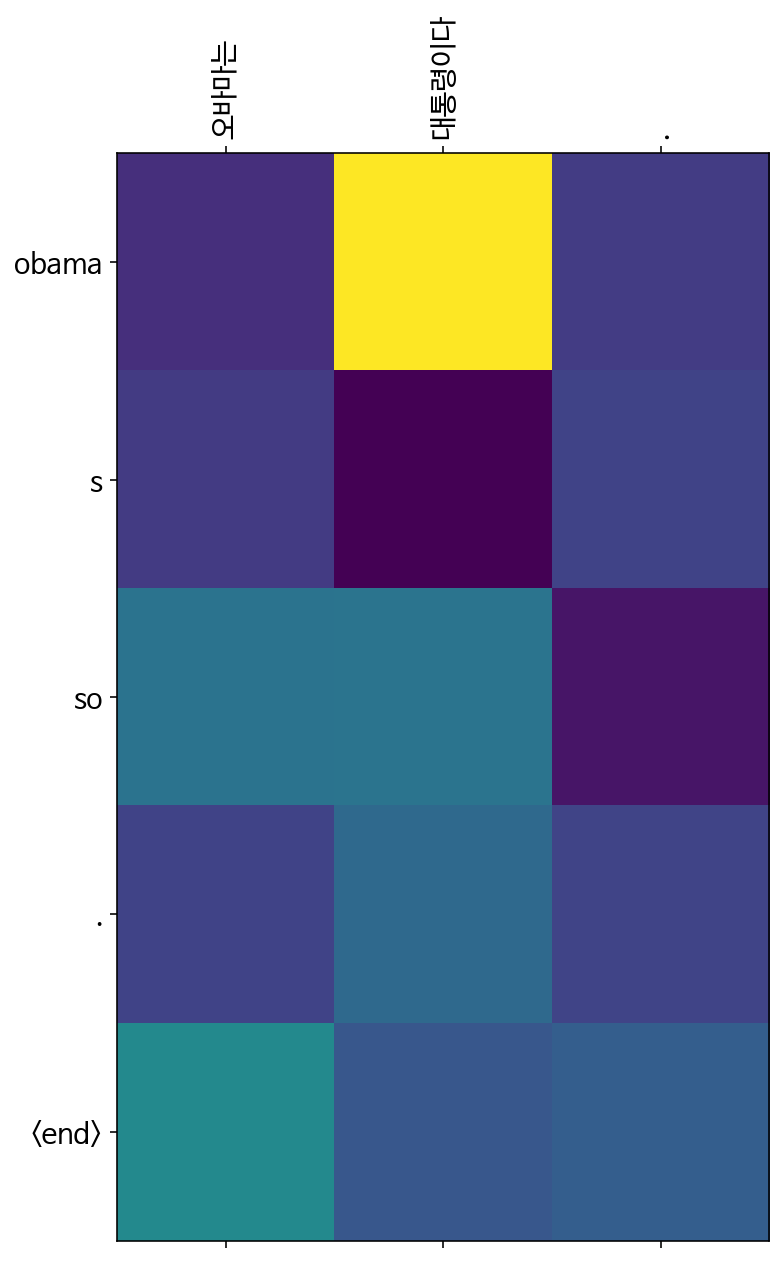

In [64]:
translate('오바마는 대통령이다.', encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the group of poway . <end> 


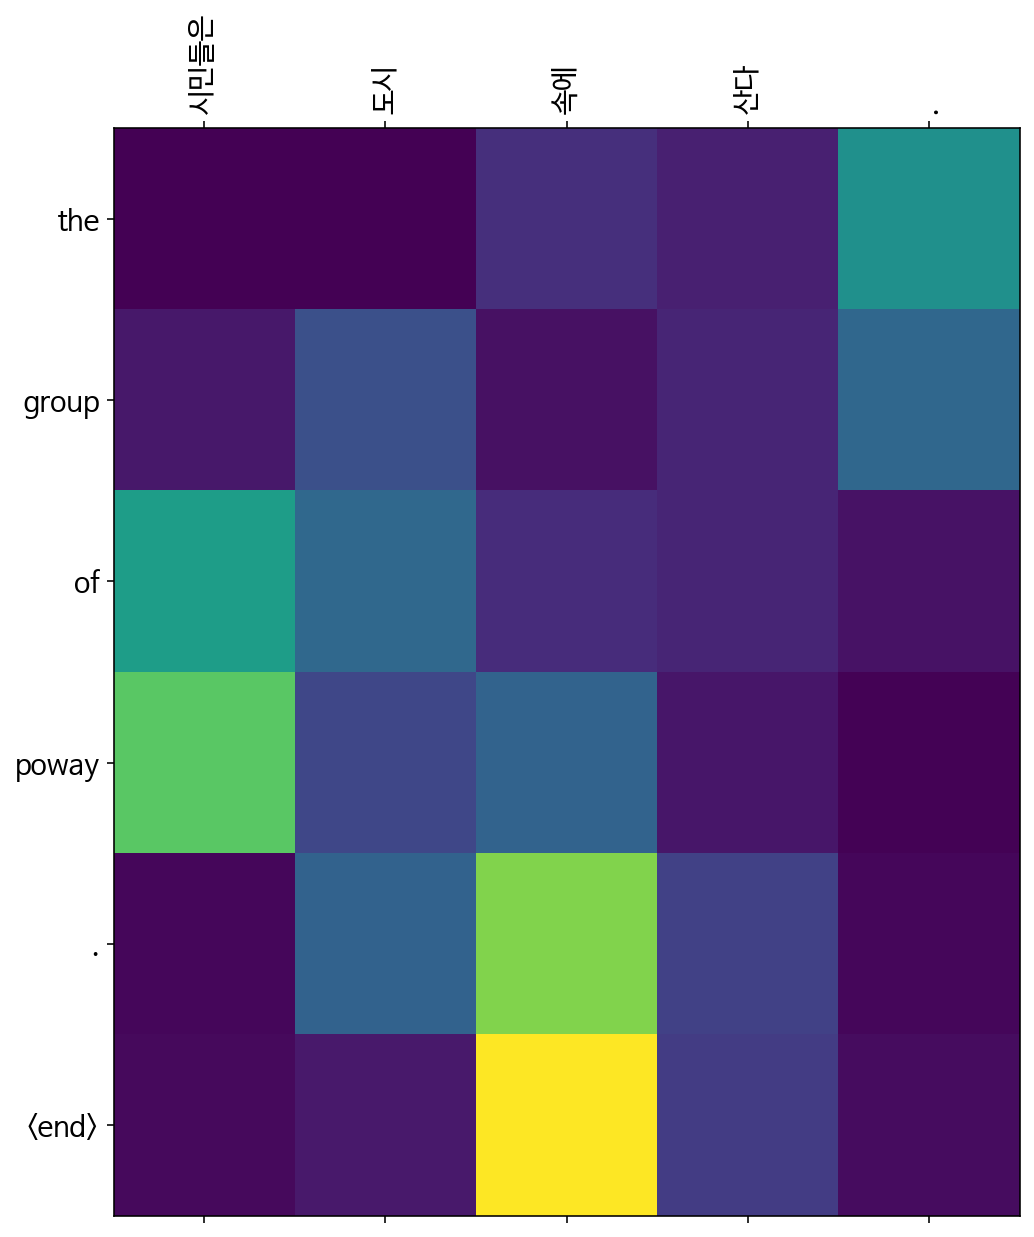

In [65]:
translate('시민들은 도시 속에 산다.', encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: doctors used his buddies is a long shot . <end> 


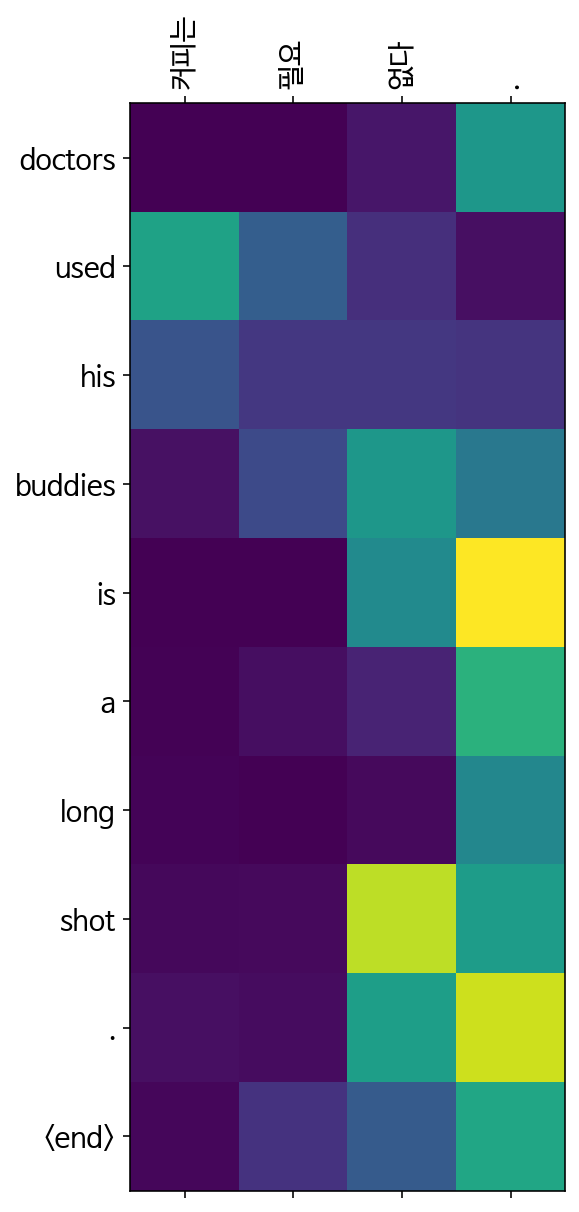

In [67]:
translate('커피는 필요 없다.', encoder, decoder)

Input: 일곱 명의 사망자 가 발생 했 다 .
Predicted translation: two people have been held in april . <end> 


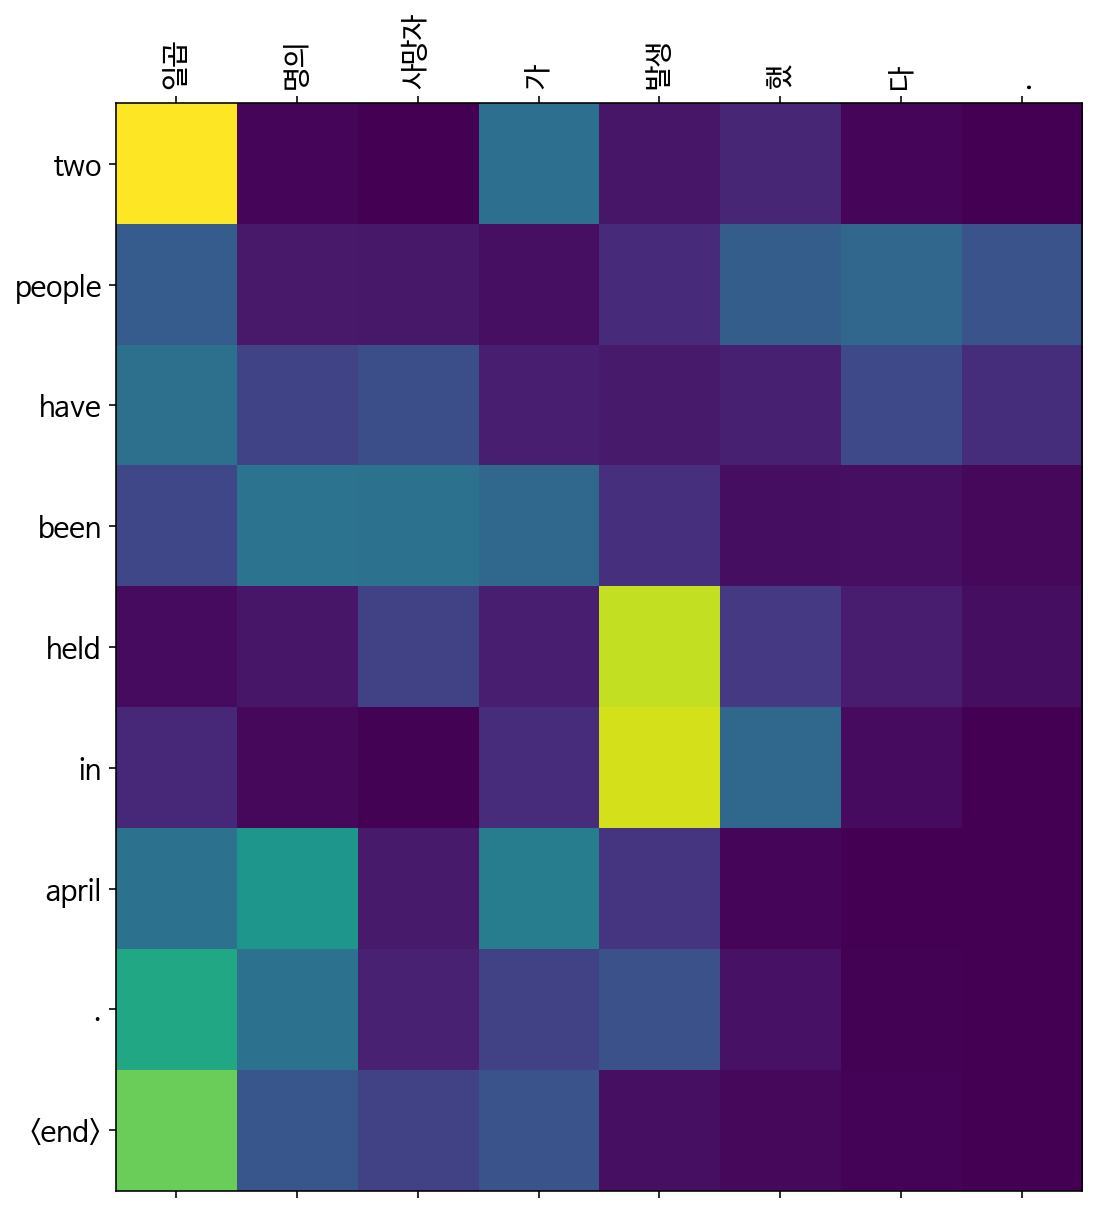

In [70]:
translate('일곱 명의 사망자 가 발생 했 다.', encoder, decoder)

\\

----

# 회고! 


### 데이터셋은 가져오면 꼭 확인 해 보자! 

- 이번 데이터셋은 다른 데이터셋에 비해, 불완전하고 이상한..? 부분이 많았다. (윗부분 참조) 지금 프로젝트와 같이 소규모의 프로젝트는 그렇게 큰 영향이 없을지도 모르지만, 후에 큰 프로젝트 를 하게된다면 분명 모델 학습에도 영향이 갈 것이다. 지금부터라도 데이터셋을 확인 해보고, 뜯어보고, 어떤 특징이 있는지 연습 해 둔다면 판다스나 넘파이 같은 데이터 툴을 다루는 데도 익숙해 질 것이고, 데이터의 특징을 좀 더 잘 파악할 수 있게 되지 않을까..? 
- 뭔가 만족스러운 분석이다! 라곤 할 순 없었지만, 이러한 특징이 있었고 저런 특징을 통해 어떻게 이용해 볼지, 제거할지 등을 생각해보는 작업은 너무 재밌었던것 같다^^)! 
- 추가로, 데이터셋이 번역만 있는게 아니라 어휘 사전 처럼 되어있는 부분도 있어서, 데이터셋을 만드신 분의 의도는 이 부분을 지우고 하시라는게 아니였을까? 라고 생각했고.. 
다음과 같은 과정을 거쳐서 데이터를 정제했었어야 했던게 아닐까..? 싶어서 어떻게 할 지 생각만 해 보았다. 실현은... 모르겠습니다 ^^.. 
    생각 한 방법!
    1.  한국어 데이터셋에서 하나하나 찾은 다음, 
 → / 가 있고, 영어와 한국어가 있다면 그 행의 인덱스를 찾고
    2.영어를 별도 리스트 하나하나에 저장 해 준 다음 
    3. 그 리스트에 있는 단어가 모두 포함된 영어 문장을 찾아서 제거하고
    4. 그 처음에 행의 인덱스에 해당 된 데이터를 한국어 데이터셋에서 지워주면..?! 